In [1]:
import numpy as np
import pandas as pd
import os
import glob
import pyarrow.parquet as pq
import datetime as dt
import networkx as nx

from plotnine import *
from mizani.formatters import percent_format, date_format, scientific_format
from mizani.breaks import date_breaks

import math
from sympy import symbols, Symbol, Eq, nsolve, solve, sqrt
from decimal import Decimal, getcontext
getcontext().prec = 50

from math import floor, log10

def format_num(num):
    rounded_num = round(num, 2 - int(math.floor(math.log10(abs(num)))) - 1)
    sci_notation = "{:.2e}".format(rounded_num)
    num_str = str(sci_notation)
    return num_str

data_dir = '/Users/zhicong/Dropbox/DEXs'
pool_name = ['DAI-USDC 100 1', 'DAI-USDC 500 10','DAI-USDC 3000 60', 'FRAX-USDC 100 1', 'FRAX-USDC 500 10','FRAX-USDC 3000 60',
             'USDC-USDT 100 1', 'USDC-USDT 500 10','USDC-USDT 3000 60', 'USDC-WETH 100 1', 'USDC-WETH 500 10','USDC-WETH 3000 60',
             'WBTC-WETH 100 1', 'WBTC-WETH 500 10','WBTC-WETH 3000 60', 'WETH-sETH2 500 10','WETH-sETH2 3000 60',
             'WETH-USDT 100 1', 'WETH-USDT 500 10','WETH-USDT 3000 60',]

# Load Data

First, we load the swap data.

In [2]:
swaps = pd.DataFrame(columns = ['BLOCK_NUMBER','BLOCK_TIMESTAMP','TX_HASH','SENDER','TX_TO','PLATFORM','POOL_NAME','CONTRACT_ADDRESS',
                                'EVENT_NAME','AMOUNT_IN','SYMBOL_IN','AMOUNT_OUT','SYMBOL_OUT'])

parquet_file = pq.ParquetFile(os.path.join(data_dir, "Data", "dex_swaps", "DEXs_swaps_full.gzip"))
# Read by batch to be able to fit dataframe into memory
for i in parquet_file.iter_batches(batch_size = 1000000):

    # Filter out only tokens we want
    temp = i.to_pandas()
    temp = temp[temp['POOL_NAME'].isin(pool_name)]

    swaps = pd.concat([swaps,temp], axis = 0)
    del temp

# Final cleaning
swaps.reset_index(drop = True, inplace = True)
swaps['BLOCK_NUMBER'] = swaps['BLOCK_NUMBER'].astype(int)
swaps['AMOUNT_IN'] = swaps['AMOUNT_IN'].astype(float)
swaps['AMOUNT_OUT'] = swaps['AMOUNT_OUT'].astype(float)
swaps['BLOCK_TIMESTAMP'] = pd.to_datetime(swaps['BLOCK_TIMESTAMP'])

swaps.sort_values(by = 'BLOCK_NUMBER', ascending = True, inplace = True)
swaps.reset_index(drop = True, inplace = True)

swaps.head()

,BLOCK_NUMBER,BLOCK_TIMESTAMP,TX_HASH,SENDER,TX_TO,PLATFORM,POOL_NAME,CONTRACT_ADDRESS,EVENT_NAME,AMOUNT_IN,SYMBOL_IN,AMOUNT_OUT,SYMBOL_OUT
0,12369886,2021-05-04 20:22:20,0x9136a3addf5ea98730b4cd1832c25a12001162cbda7c...,0xe592427a0aece92de3edee1f18e0157c05861564,0xdd0d6c26a03d6f6541471d44179f56d478f50f6b,uniswap-v3,WBTC-WETH 3000 60,0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,Swap,0.010000,WETH,0.000622,WBTC
1,12369910,2021-05-04 20:25:37,0x06e53c0e241686b10a7e3aa5d3af706144a486d291e2...,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,uniswap-v3,USDC-USDT 500 10,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,Swap,5.072623,USDT,5.070084,USDC
2,12369910,2021-05-04 20:25:37,0x06e53c0e241686b10a7e3aa5d3af706144a486d291e2...,0xe592427a0aece92de3edee1f18e0157c05861564,0x11e4857bb9993a50c685a79afad4e6f65d518dda,uniswap-v3,DAI-USDC 500 10,0x6c6bc977e13df9b0de53b251522280bb72383700,Swap,5.070084,USDC,5.068032,DAI
3,12369941,2021-05-04 20:32:14,0x83f0e6c10439fe18108b7431a00fed8aad92d6028441...,0xe592427a0aece92de3edee1f18e0157c05861564,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,uniswap-v3,DAI-USDC 500 10,0x6c6bc977e13df9b0de53b251522280bb72383700,Swap,10.000000,DAI,9.994027,USDC
4,12369971,2021-05-04 20:38:51,0x2d4763faa40fc2d6cdf7f8afeab5448c755ce3279085...,0xe592427a0aece92de3edee1f18e0157c05861564,0xdd0d6c26a03d6f6541471d44179f56d478f50f6b,uniswap-v3,DAI-USDC 500 10,0x6c6bc977e13df9b0de53b251522280bb72383700,Swap,33.465884,USDC,33.452115,DAI


To get trading volume, we use the USD value the tokens at the time of transaction. The sources of this data are CoinMarketCap and CoinGecko.

In [5]:
token_prices = pd.DataFrame(columns = ['hour','symbol','price'])

for file_name in os.listdir(os.path.join(data_dir, "Data", "token_prices")):
    if file_name.endswith(".csv"):
        temp = pd.read_csv(os.path.join(data_dir, "Data", "token_prices", file_name))
        token_prices = pd.concat([token_prices,temp], axis = 0)

token_prices['hour'] = pd.to_datetime(token_prices['hour']).dt.tz_localize(None)

# Merge token prices
swaps['hour'] = swaps['BLOCK_TIMESTAMP'].dt.floor("H")

swaps['PRICE_IN'] = pd.merge(swaps[['hour','SYMBOL_IN']], token_prices, how = 'left', left_on = ['hour','SYMBOL_IN'], right_on = ['hour','symbol'])['price']
swaps['PRICE_OUT'] = pd.merge(swaps[['hour','SYMBOL_OUT']], token_prices, how = 'left', left_on = ['hour','SYMBOL_OUT'], right_on = ['hour','symbol'])['price']
swaps['USD_IN'] = swaps['AMOUNT_IN'] * swaps['PRICE_IN']
swaps['USD_OUT'] = swaps['AMOUNT_OUT'] * swaps['PRICE_OUT']
swaps['USD_volume'] = (swaps['USD_IN'] + swaps['USD_OUT'])/2

swaps = swaps[['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP','SENDER','SYMBOL_IN','USD_IN','SYMBOL_OUT','USD_OUT','USD_volume']]

swaps.head()

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,SYMBOL_IN,USD_IN,SYMBOL_OUT,USD_OUT,USD_volume
0,WBTC-WETH 3000 60,12369886,2021-05-04 20:22:20,0xe592427a0aece92de3edee1f18e0157c05861564,WETH,34.033464,WBTC,34.095007,34.064235
1,USDC-USDT 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDT,5.073304,USDC,5.069820,5.071562
2,DAI-USDC 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,5.069820,DAI,5.072173,5.070997
3,DAI-USDC 500 10,12369941,2021-05-04 20:32:14,0xe592427a0aece92de3edee1f18e0157c05861564,DAI,10.008172,USDC,9.993506,10.000839
4,DAI-USDC 500 10,12369971,2021-05-04 20:38:51,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,33.464141,DAI,33.479452,33.471797


# Labelling

Here, we will label known addresses, particularly Routers and MEV bots, sources of data is from brainleect's Github folder "https://github.com/brianleect/etherscan-labels/tree/main".

In [6]:
# Get all csv files
all_csv_files = [file for path, subdir, files in os.walk(os.path.join(data_dir, "Data", "brianleect_etherscan_labels_data", "etherscan", "accounts"))
                      for file in glob.glob(os.path.join(path, "*.csv"))]

# Read csv files
all_labels = pd.DataFrame(columns = ['Address','Name Tag','Balance','Txn Count'])

for file_name in all_csv_files:
    temp = pd.read_csv(file_name)
    all_labels = pd.concat([all_labels,temp], axis = 0)

all_labels = all_labels[['Address','Name Tag','Txn Count']]
all_labels.rename(columns = {'Address':'SENDER', 'Name Tag':'name_tag'}, inplace = True)

print("Number of Labels:", len(all_labels))
all_labels.head()

Number of Labels: 26065


,SENDER,name_tag,Txn Count
0,0x887e81cab04461620a5ff196048bba38d9dc96e4,UNCX Network: Staking pool Tier 1,580
1,0x2a17c35ff147b32f13f19f2e311446eeb02503f3,0x: Staking,14
2,0xa26e80e7dea86279c6d778d702cc413e6cffa777,0x: Staking Proxy V3,34769
3,0xba7f8b5fb1b19c1211c5d49550fcd149177a5eaf,0x: ZRX Vault V3,25
4,0xe194d30afdbae89b3118b8b7bc7b331cc3333b88,Accumulated Finance: stACME Staking Rewards,92


Merge with transaction data.

In [7]:
swaps = swaps.merge(all_labels[['SENDER','name_tag']], on = 'SENDER', how = 'left')

print("Percentage of labelled addresses:", str(round((1-swaps['name_tag'].isna().sum()/len(swaps))*100,2)) + '%')
swaps.head()

Percentage of labelled addresses: 88.54%


,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,SYMBOL_IN,USD_IN,SYMBOL_OUT,USD_OUT,USD_volume,name_tag
0,WBTC-WETH 3000 60,12369886,2021-05-04 20:22:20,0xe592427a0aece92de3edee1f18e0157c05861564,WETH,34.033464,WBTC,34.095007,34.064235,Uniswap V3: Router
1,USDC-USDT 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDT,5.073304,USDC,5.069820,5.071562,Uniswap V3: Router
2,DAI-USDC 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,5.069820,DAI,5.072173,5.070997,Uniswap V3: Router
3,DAI-USDC 500 10,12369941,2021-05-04 20:32:14,0xe592427a0aece92de3edee1f18e0157c05861564,DAI,10.008172,USDC,9.993506,10.000839,Uniswap V3: Router
4,DAI-USDC 500 10,12369971,2021-05-04 20:38:51,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,33.464141,DAI,33.479452,33.471797,Uniswap V3: Router


We are also interested in the entities that are labelled.

In [8]:
swaps.groupby(['name_tag']).size().sort_values(ascending = False).reset_index(name = 'no_transactions').head(20)

,name_tag,no_transactions
0,Uniswap V3: Router,2455755
1,Uniswap V3: Router 2,2425540
2,0x: Exchange Proxy,1410294
3,Uniswap: Old Universal Router,941131
4,1inch v4: Aggregation Router,779526
5,1inch v5: Aggregation Router,308164
6,MEV Bot: 0x4Cb...8e7,285517
7,MEV Bot: 0xA69...78C,281076
8,MEV Bot: 0xBEE...638,148578
9,1inch: Aggregation Executor,101520


The above table is in terms of transactions.

In [9]:
swaps.groupby(['name_tag'])['USD_volume'].sum().sort_values(ascending = False).reset_index(name = 'USD_volume').head(20)

,name_tag,USD_volume
0,Uniswap V3: Router 2,4.000032e+13
1,Uniswap V3: Router,3.486744e+13
2,MEV Bot: 0x4Cb...8e7,3.404466e+13
3,MEV Bot: 0x8aF...580,2.403582e+13
4,0x: Exchange Proxy,1.824537e+13
5,MEV Bot: 0xA69...78C,1.804027e+13
6,1inch v4: Aggregation Router,1.765465e+13
7,MEV Bot: 0xBEE...638,1.669213e+13
8,1inch: Aggregation Executor,9.614063e+12
9,Uniswap: Old Universal Router,9.389906e+12


# Analysis

We can now analysis trades.

## Basic Statistics

In [10]:
print('Total number of swaps:', len(swaps))
print('Total number of unique traders:', len(swaps['SENDER'].unique()))

Total number of swaps: 11345507
Total number of unique traders: 1922


## Pools

We are interested in the trading volume by pools.

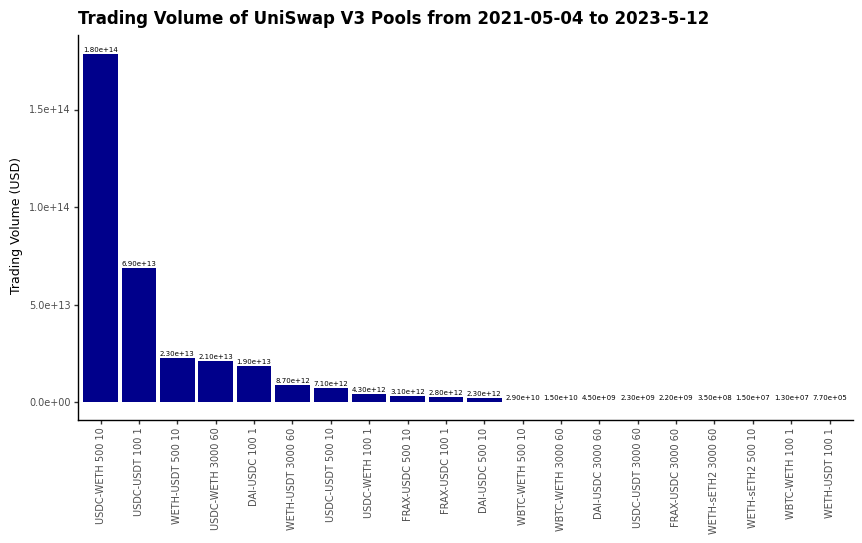

In [11]:
trading_volume_by_pool = swaps.groupby(['POOL_NAME'])['USD_volume'].sum().sort_values(ascending = False).reset_index(name = 'volume')
trading_volume_by_pool['label'] = [format_num(num) for num in trading_volume_by_pool['volume']]

fig = (
ggplot(trading_volume_by_pool) + 
    geom_col(aes(x = 'reorder(POOL_NAME,-volume)', y = 'volume'), fill = 'darkblue') + 
    geom_text(aes(x = 'reorder(POOL_NAME,-volume)', y = 'volume', label = 'label'), va = 'bottom', ha = 'center', nudge_y = 1e+12, size = 5) +

    scale_y_continuous(labels = scientific_format(digits=2)) +
        
    theme_classic() +
    theme(plot_title = element_text(size = 12, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 7, angle = 90),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          figure_size = (10,5)) +
    labs(title = 'Trading Volume of UniSwap V3 Pools from 2021-05-04 to 2023-5-12',
         x = '', y = 'Trading Volume (USD)')
)

#fig.save('./Plots/Trading Volume of UniSwap V3 Pools from 2021-05-04 to 2023-5-12.png', dpi = 1000)

print(fig)

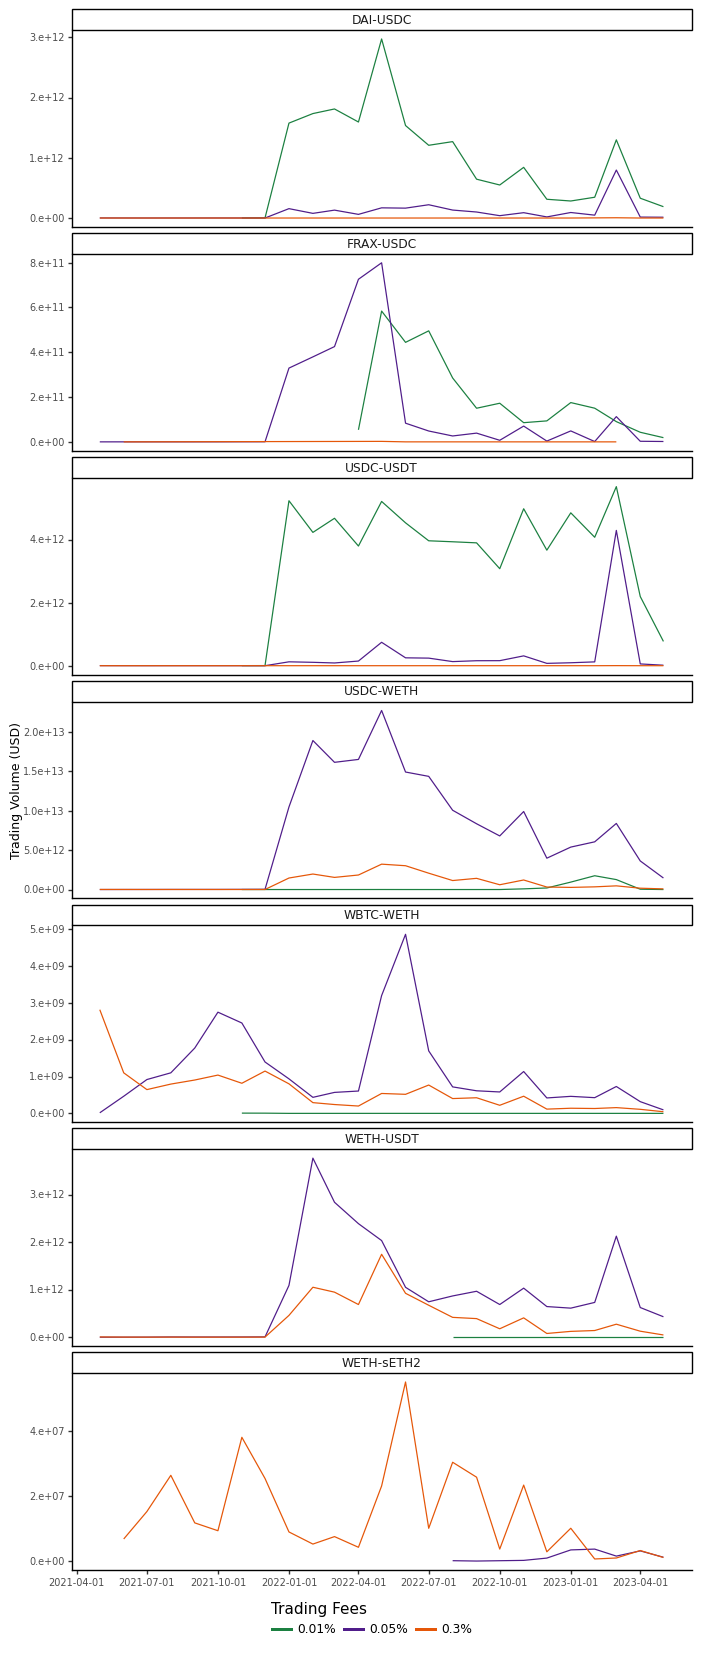

In [12]:
swaps['month'] = swaps['BLOCK_TIMESTAMP'].dt.to_period('M').dt.to_timestamp()

trading_volume_by_month = swaps.groupby(['POOL_NAME','month'])['USD_volume'].sum().sort_values(ascending = False).reset_index(name = 'volume')
trading_volume_by_month['token_pair'] = trading_volume_by_month['POOL_NAME'].str.split(' ').str[0]
trading_volume_by_month['Trading Fees'] = trading_volume_by_month['POOL_NAME'].str.split(' ').str[1].replace({'100':'0.01%','500':'0.05%','3000':'0.3%'})

fig = (
ggplot(trading_volume_by_month) + 
    geom_line(aes(x = 'month', y = 'volume', color = 'Trading Fees')) + 

    facet_wrap('token_pair', scales = 'free_y', ncol = 1) +

    scale_y_continuous(labels = scientific_format(digits=2)) +

    scale_color_manual(values = ['#1c8041','#501d8a','#e55709']) +
        
    theme_classic() +
    theme(plot_title = element_text(size = 12, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 7),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          legend_position = 'bottom',
          figure_size = (8,20)) +
    labs(title = '', x = '', y = 'Trading Volume (USD)')
)

#fig.save('./Plots/Trading Volume of UniSwap V3 Pools by Month.png', dpi = 1000)

print(fig)

## Traders

Next, we want to look at the distribution of traders.

In [13]:
trade_concentration = swaps.groupby(['SENDER'])['USD_volume'].sum().sort_values(ascending = False).reset_index(name = 'volume')
trade_concentration['total_volume'] = trade_concentration['volume'].sum()
trade_concentration['perc_volume'] = round(trade_concentration['volume']/trade_concentration['total_volume'], 2)
trade_concentration = trade_concentration[['SENDER','volume','perc_volume']]
trade_concentration.head()

,SENDER,volume,perc_volume
0,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,4.000032e+13,0.12
1,0xe592427a0aece92de3edee1f18e0157c05861564,3.486744e+13,0.10
2,0x4cb18386e5d1f34dc6eea834bf3534a970a3f8e7,3.404466e+13,0.10
3,0x8aff5ca996f77487a4f04f1ce905bf3d27455580,2.403582e+13,0.07
4,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.824537e+13,0.05


/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1822 rows containing missing values.


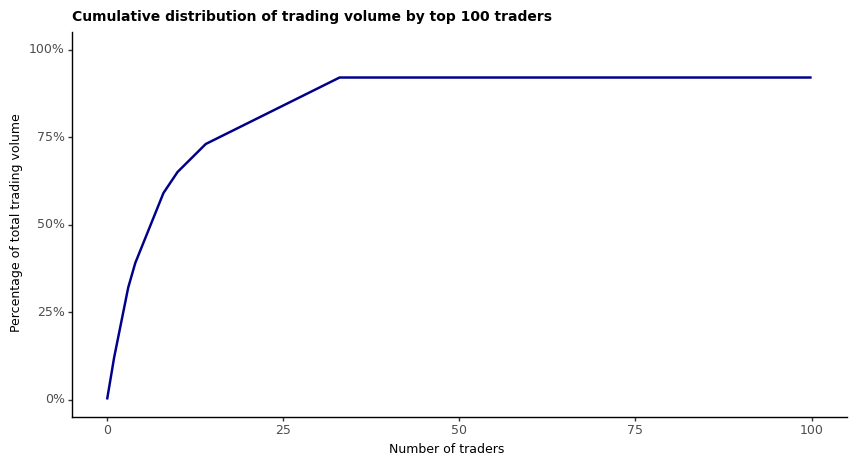

In [14]:
trade_concentration['cum_perc_volume'] = trade_concentration['perc_volume'].cumsum()
trade_concentration['no_sender'] = np.arange(1,len(trade_concentration)+1,1)

fig = (
ggplot(pd.concat([pd.DataFrame({'no_sender':[0], 'cum_perc_volume':[0]}), trade_concentration], ignore_index = True)) + 
    geom_line(aes(x = 'no_sender', y = 'cum_perc_volume'), color = 'darkblue', size = 1) + 
    
    scale_y_continuous(labels = percent_format(), limits = (0,1)) +
    xlim(0,100) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Cumulative distribution of trading volume by top 100 traders',
         x = 'Number of traders', y = 'Percentage of total trading volume')
)

#fig.save('./Plots/Cumulative distribution of trading volume by top 100 traders', dpi = 1000)

print(fig)

We can also track how the concentration changes over time.

In [15]:
concentration_by_month = swaps.groupby(['SENDER','month'])['USD_volume'].sum().reset_index()

# Pivot into a dataframe with rows being timestamp and columns being addresses
concentration_by_month = concentration_by_month.pivot(index = 'month', columns = 'SENDER', values = 'USD_volume')
concentration_by_month.fillna(0, inplace = True)
concentration_by_month = concentration_by_month.apply(np.cumsum)

# Solve rounding errors
concentration_by_month[concentration_by_month < 0.1] = 0
concentration_by_month['total'] = concentration_by_month.sum(axis = 1)

# Get top n LPs and total LP of the pool
n = 100
concentration_by_month = concentration_by_month.apply(np.sort, args = (), axis = 1).apply(lambda x: x[-(n+1):]).apply(pd.Series)
concentration_by_month.columns = ['num_' + str(i) for i in np.arange(n,0,-1)] + ['total']

concentration_by_month['top1_total'] = concentration_by_month.loc[:,['num_' + str(i) for i in np.arange(1,1+1,1)]].sum(axis = 1)
concentration_by_month['top2-5_total'] = concentration_by_month.loc[:,['num_' + str(i) for i in np.arange(2,5+1,1)]].sum(axis = 1)
concentration_by_month['top6-10_total'] = concentration_by_month.loc[:,['num_' + str(i) for i in np.arange(6,10+1,1)]].sum(axis = 1)
concentration_by_month['top11-100_total'] = concentration_by_month.loc[:,['num_' + str(i) for i in np.arange(11,100+1,1)]].sum(axis = 1)

concentration_by_month['Top1'] = round(concentration_by_month['top1_total']/concentration_by_month['total'],5)
concentration_by_month['Top2-5'] = round(concentration_by_month['top2-5_total']/concentration_by_month['total'],5)
concentration_by_month['Top6-10'] = round(concentration_by_month['top6-10_total']/concentration_by_month['total'],5)
concentration_by_month['Top11-100'] = round(concentration_by_month['top11-100_total']/concentration_by_month['total'],5)
concentration_by_month['Rest'] = 1 - concentration_by_month[['Top1','Top2-5','Top6-10','Top11-100']].sum(axis = 1)

concentration_by_month = concentration_by_month[['Top1','Top2-5','Top6-10','Top11-100','Rest']]
concentration_by_month.reset_index(inplace = True)

concentration_by_month.head(10)

,month,Top1,Top2-5,Top6-10,Top11-100,Rest
0,2021-05-01,0.74920,0.23843,0.00939,0.00298,0.00000
1,2021-06-01,0.76279,0.20131,0.02329,0.01261,0.00000
2,2021-07-01,0.75787,0.17726,0.03705,0.02782,0.00000
3,2021-08-01,0.74212,0.14230,0.05650,0.05887,0.00021
4,2021-09-01,0.70899,0.13969,0.08406,0.06668,0.00058
5,2021-10-01,0.67658,0.14822,0.09865,0.07487,0.00168
6,2021-11-01,0.64131,0.14732,0.10988,0.09872,0.00277
7,2021-12-01,0.58932,0.17685,0.11147,0.11858,0.00378
8,2022-01-01,0.28187,0.40682,0.21840,0.09264,0.00027
9,2022-02-01,0.26959,0.43237,0.19904,0.09826,0.00074


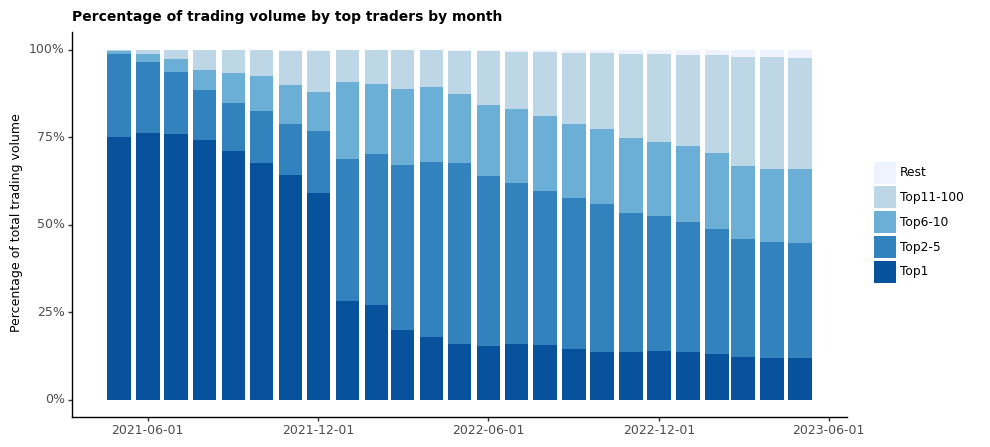

In [16]:
plot_data = concentration_by_month.melt(id_vars = 'month')
plot_data['variable'] = pd.Categorical(plot_data['variable'], categories = ['Rest','Top11-100','Top6-10','Top2-5','Top1'], ordered = True)

fig = (
ggplot(plot_data, aes(x = 'month', y = 'value', fill = 'variable')) +
    
    geom_bar(position = 'fill', stat = 'identity') + 
    
    scale_x_datetime(breaks = date_breaks('6 months')) +
    scale_y_continuous(labels = percent_format()) +
    
    scale_fill_brewer(type = 'seq', palette = 1) +
    theme_classic() + 
    theme(plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          legend_position = 'right',
          legend_title = element_blank(),
          figure_size = (10,5)) +
    labs(title = 'Percentage of trading volume by top traders by month',
         x = '', y = 'Percentage of total trading volume')
)

#fig.save('./Plots/Percentage of trading volume by top traders by month.png', dpi = 1000)

print(fig)

We can see that trades are super concentrated as well, especially during the early phrases of Uniswap V3.

In [17]:
swaps

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,SYMBOL_IN,USD_IN,SYMBOL_OUT,USD_OUT,USD_volume,name_tag,month
0,WBTC-WETH 3000 60,12369886,2021-05-04 20:22:20,0xe592427a0aece92de3edee1f18e0157c05861564,WETH,3.403346e+01,WBTC,34.095007,3.406424e+01,Uniswap V3: Router,2021-05-01
1,USDC-USDT 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDT,5.073304e+00,USDC,5.069820,5.071562e+00,Uniswap V3: Router,2021-05-01
2,DAI-USDC 500 10,12369910,2021-05-04 20:25:37,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,5.069820e+00,DAI,5.072173,5.070997e+00,Uniswap V3: Router,2021-05-01
3,DAI-USDC 500 10,12369941,2021-05-04 20:32:14,0xe592427a0aece92de3edee1f18e0157c05861564,DAI,1.000817e+01,USDC,9.993506,1.000084e+01,Uniswap V3: Router,2021-05-01
4,DAI-USDC 500 10,12369971,2021-05-04 20:38:51,0xe592427a0aece92de3edee1f18e0157c05861564,USDC,3.346414e+01,DAI,33.479452,3.347180e+01,Uniswap V3: Router,2021-05-01
...,...,...,...,...,...,...,...,...,...,...,...
11345502,WETH-USDT 500 10,17244712,2023-05-12 14:25:59,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,USDT,2.446000e+06,WETH,1.125020,1.223001e+06,Uniswap: Old Universal Router,2023-05-01
11345503,WETH-USDT 500 10,17244712,2023-05-12 14:25:59,0x1111111254eeb25477b68fb85ed929f73a960582,USDT,1.000000e+03,WETH,0.562519,5.002813e+02,1inch v5: Aggregation Router,2023-05-01
11345504,WETH-USDT 500 10,17244712,2023-05-12 14:25:59,0x1111111254eeb25477b68fb85ed929f73a960582,USDT,1.000000e+03,WETH,0.562519,5.002813e+02,1inch v5: Aggregation Router,2023-05-01
11345505,WETH-USDT 500 10,17244714,2023-05-12 14:26:23,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,USDT,1.316055e+02,WETH,0.074029,6.583974e+01,Uniswap: Old Universal Router,2023-05-01
